In [315]:
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import atan2, cos, sin, degrees, radians, log

import warnings
warnings.filterwarnings('ignore')



# Load Data

In [2]:
df_trap = gpd.read_file('../data/Processed data/trap.geojson')
df_trap

,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,latitude,longitude,location,month,result_b,year_week,geometry
0,2021,39,53373,12XX W GREENLEAF AVE,T018,GRAVID,2021-09-30T00:09:00,2,negative,CULEX PIPIENS/RESTUANS,42.010529,-87.660845,"{'latitude': '42.01052928915475', 'longitude':...",9,0,2021/W39,POINT (-87.66085 42.01053)
1,2021,39,53381,61XX W FULLERTON AVE,T013,GRAVID,2021-09-30T00:09:00,13,negative,CULEX PIPIENS/RESTUANS,41.923887,-87.778910,"{'latitude': '41.92388736426867', 'longitude':...",9,0,2021/W39,POINT (-87.77891 41.92389)
2,2021,39,53406,10XX E 67TH ST,T073,GRAVID,2021-09-30T00:09:00,7,negative,CULEX PIPIENS/RESTUANS,41.773085,-87.600168,"{'latitude': '41.773085401492715', 'longitude'...",9,0,2021/W39,POINT (-87.60017 41.77309)
3,2021,39,53401,52XX W 63RD ST,T065,GRAVID,2021-09-30T00:09:00,8,negative,CULEX PIPIENS/RESTUANS,41.778305,-87.754366,"{'latitude': '41.77830515554422', 'longitude':...",9,0,2021/W39,POINT (-87.75437 41.77831)
4,2021,39,53383,5XX S CENTRAL AVE,T031,GRAVID,2021-09-30T00:09:00,5,positive,CULEX PIPIENS/RESTUANS,41.872873,-87.764737,"{'latitude': '41.87287286249572', 'longitude':...",9,1,2021/W39,POINT (-87.76474 41.87287)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,42.017801,-87.687601,"{'latitude': '42.0178008501155', 'longitude': ...",5,0,2007/W21,POINT (-87.68760 42.01780)
32874,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,41.688171,-87.678252,"{'latitude': '41.688170589570205', 'longitude'...",5,0,2007/W21,POINT (-87.67825 41.68817)
32875,2007,21,20051,2XX W 89TH ST,T096,CDC,2007-05-29T00:05:00,5,negative,CULEX RESTUANS,41.732428,-87.631056,"{'latitude': '41.73242806400838', 'longitude':...",5,0,2007/W21,POINT (-87.63106 41.73243)
32876,2007,21,20031,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00,2,negative,CULEX PIPIENS/RESTUANS,41.922512,-87.632378,"{'latitude': '41.922512376871495', 'longitude'...",5,0,2007/W21,POINT (-87.63238 41.92251)


In [3]:
water_df = gpd.read_file('../data/Processed data/water.geojson')
michLake = gpd.read_file('../data/Processed data/michLake.geojson')
spray = gpd.read_file("../data/Processed data/spray.geojson")

In [4]:
water_df = gpd.GeoDataFrame(water_df, crs="EPSG:4326",geometry='geometry')


In [5]:
forestry = gpd.read_file("../data/Forestry/Forestry.shp")
park = gpd.read_file("../data/Parks - Chicago Park District Park Boundaries (current).geojson")
forestry = forestry.to_crs(park.crs)

In [6]:
weather = pd.read_csv('../data/Processed data/weather.csv')

In [7]:
sanitation = gpd.read_file("../data/Processed data/sanitation.geojson")

# feature engineering

### Distance to geospatial features

In [8]:
# all these location feature are multipolygon, gotta convert it to distance

In [9]:

    # GEODATAFRAME THAT WILL BE POINTS
    # "RIVERS TO COMPARE AGAINST"


def polygon_to_multipoints(multipoligons):
        # MULTIPOINT FUNCTION
        from shapely.geometry import MultiPoint

        # GET ONE LARGE LIST OF POLYGONS
        polygons = []

        [
            # EXTEND LIST OF POLYGONS
            polygons.extend(
                # TURN MULTIPOLYGON GEOMETRY TO LIST OF SINGLE POLYGONS
                list(multipolys)
                )
            # CYCLE THROUGH THE DISTRICT GEOMETRIES
            for multipolys in multipoligons['geometry'].values
            ]


        # GET ONE LARGE LIST OF POINTS
        points = []

        [   
            # EXTEND POINT LIST
            points.extend(
                # GET LIST OF POINTS FROM THE EXTERIOR OF EACH POLYGON
                list(polygon.exterior.coords)
                ) 
            for polygon in polygons
        ]
        # GEOMETRY OF MULTIPLE POINTS
        return MultiPoint(points)


def nearest_distance(multipoints,points): # get the nearest distance from every point in a set to a multipoints object

        # MAIN COMPARISION POLYGONS is 'points'
        # FIND NEAREST POINTS FUNCTION
        from shapely.ops import nearest_points

        # GET NEW COLUMN OF NEAREST DISTANCE
        return points.geometry.apply(
            # CYCLE THROUGH EACH GEOMETRY
            lambda geom: 
            # FIND DISTANCE BETWEEN GEOM AND NEAREST POINT
            geom.distance(
                # FIND NEAREST POINT
                nearest_points(multipoints, geom)[0]
                )
            )
        
def nearest_distance_from_point_to_polygons(multipoligons,points):

    # turn multi-polygons to multi-points
        multipoints = polygon_to_multipoints(multipoligons)
        return nearest_distance(multipoints,points)


In [10]:
df_trap['distance_to_water'] = nearest_distance_from_point_to_polygons(water_df,df_trap)
df_trap['distance_to_michLake'] = nearest_distance_from_point_to_polygons(michLake,df_trap)

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/920424144.py:16: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(multipolys)
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/920424144.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(multipolys)
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/920424144.py:16: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(multipolys)
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/9204241

In [11]:
df_trap['distance_to_parks'] = nearest_distance_from_point_to_polygons(park,df_trap)


/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/920424144.py:16: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(multipolys)
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/920424144.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(multipolys)


In [12]:
# df_trap['distance_to_forest'] = nearest_distance(forestry,df_trap)

In [13]:
df_trap['week'] = df_trap['week'].astype('int64')

In [14]:
df_trap.columns

Index(['season_year', 'week', 'test_id', 'block', 'trap', 'trap_type',
       'test_date', 'number_of_mosquitoes', 'result', 'species', 'latitude',
       'longitude', 'location', 'month', 'result_b', 'year_week', 'geometry',
       'distance_to_water', 'distance_to_michLake', 'distance_to_parks'],
      dtype='object')

### add weather feature

In [15]:
weather.drop('Unnamed: 0',axis=1,inplace=True)

In [16]:
weather.columns

Index(['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WSF2', 'WT01', 'WT02',
       'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT10', 'tavg',
       'year_week'],
      dtype='object')

In [17]:
weather_by_week_1 = weather.groupby('year_week').mean()[['AWND','PRCP','tavg','WDF2']].reset_index()
weather_by_week_2 = weather.groupby('year_week').sum()[['WT01','WT02','WT03','WT04','WT05','WT06', 'WT08', 'WT09', 'WT10']].reset_index()

In [18]:
weather_by_week = pd.merge(weather_by_week_1,weather_by_week_2,how='inner',on='year_week')
weather_by_week

,year_week,AWND,PRCP,tavg,WDF2,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10
0,2007/W01,5.140000,0.110000,28.000000,320.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007/W09,16.835000,0.095000,29.375000,227.500000,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
2,2007/W10,8.341429,0.027143,32.857143,161.428571,6.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,2007/W11,11.472857,0.030000,42.214286,107.142857,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,2007/W12,10.992857,0.222857,51.714286,142.857143,5.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,2021/W49,11.950000,0.114286,34.928571,217.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775,2021/W50,12.365714,0.025714,43.642857,202.857143,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
776,2021/W51,9.648571,0.022857,38.357143,194.285714,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
777,2021/W52,8.098000,0.130000,37.700000,140.000000,5.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0


In [19]:
df = pd.merge(df_trap,weather_by_week,how='left',on='year_week')

### add sanitation data

In [20]:
print(df['year_week'].min(),
  df['year_week'].max())

2007/W21 2021/W39


In [21]:
sanitation = sanitation[(sanitation['year_week'] >= '2007/W21') & (sanitation['year_week'] <= '2021/W39')]

In [22]:
from shapely.geometry import MultiPoint
year_week_ = []
geometry_ = []
sanitation_week = sanitation['year_week'].unique() # get a list of all weeks


for i in sanitation_week:
  point_list = list(sanitation[sanitation['year_week'] == i]['geometry'])
  point_list = MultiPoint(point_list)

  geometry_.append(point_list)
  year_week_.append(i)
  

In [23]:
# now calculate the distance from traps to nearest sanitation violation. 
# First turn the sanitation points in each week into a multipoint object.

sanitation_by_weeks = pd.DataFrame([geometry_,year_week_]).T
sanitation_by_weeks.columns = ['geometry','year_week']
sanitation_by_weeks = gpd.GeoDataFrame(sanitation_by_weeks, geometry=geometry_)

In [24]:
sanitation_by_weeks.head()

,geometry,year_week
0,"MULTIPOINT (-87.73373 41.77787, -87.72085 41.7...",2017/W37
1,"MULTIPOINT (-87.70420 41.96121, -87.73860 41.7...",2017/W40
2,"MULTIPOINT (-87.67611 41.86125, -87.67212 41.7...",2017/W34
3,"MULTIPOINT (-87.76161 41.77519, -87.73249 41.7...",2017/W38
4,"MULTIPOINT (-87.62254 41.73400, -87.70121 41.7...",2017/W39


In [25]:
# index_ = sanitation_by_weeks[sanitation_by_weeks['year_week'] == "2017/W39"].index
# why these two are different types????????????????????
# sanitation_by_weeks['geometry'].iloc[index_]
# sanitation_by_weeks['geometry'].iloc[6]

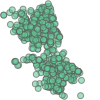

In [26]:
sanitation_by_weeks['geometry'].iloc[6]

In [27]:
df['distance_to_bad_santination'] = np.nan
from shapely.ops import nearest_points
for i in np.arange(0,500):
  if df['year_week'][i] in sanitation_by_weeks['year_week'].values: # ”values“ is important here
    year_week_ = df['year_week'][i]
    index_ = sanitation_by_weeks[sanitation_by_weeks['year_week'] == year_week_].index.values[0] # why .index.values and then [0]??!! I spent 5 hours on this!!
    df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
        nearest_points(
          sanitation_by_weeks['geometry'][index_],
          df['geometry'][i]
      )[0]
    )

  

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_bad_santination'][i] = df['geometry'][i].distance(
/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2694817686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [28]:
df[df['distance_to_bad_santination'].isna() == True]

,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,...,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,distance_to_bad_santination
500,2021,33,52986,100XX W OHARE AIRPORT,T905,GRAVID,2021-08-19T00:08:00,1,negative,CULEX RESTUANS,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
501,2021,33,52906,71XX N HARLEM AVE,T233,GRAVID,2021-08-19T00:08:00,8,negative,CULEX PIPIENS/RESTUANS,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
502,2021,33,52992,100XX W OHARE,T909,GRAVID,2021-08-19T00:08:00,50,positive,CULEX PIPIENS/RESTUANS,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
503,2021,33,52969,9XX W GARFIELD BLVD,T226,GRAVID,2021-08-19T00:08:00,47,negative,CULEX PIPIENS/RESTUANS,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
504,2021,33,52948,22XX N CANNON DR,T054B,GRAVID,2021-08-19T00:08:00,1,negative,CULEX PIPIENS/RESTUANS,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,...,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
32874,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,...,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
32875,2007,21,20051,2XX W 89TH ST,T096,CDC,2007-05-29T00:05:00,5,negative,CULEX RESTUANS,...,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
32876,2007,21,20031,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00,2,negative,CULEX PIPIENS/RESTUANS,...,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN


In [29]:
df.head()

,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,...,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,distance_to_bad_santination
0,2021,39,53373,12XX W GREENLEAF AVE,T018,GRAVID,2021-09-30T00:09:00,2,negative,CULEX PIPIENS/RESTUANS,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.009930
1,2021,39,53381,61XX W FULLERTON AVE,T013,GRAVID,2021-09-30T00:09:00,13,negative,CULEX PIPIENS/RESTUANS,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.013229
2,2021,39,53406,10XX E 67TH ST,T073,GRAVID,2021-09-30T00:09:00,7,negative,CULEX PIPIENS/RESTUANS,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.004155
3,2021,39,53401,52XX W 63RD ST,T065,GRAVID,2021-09-30T00:09:00,8,negative,CULEX PIPIENS/RESTUANS,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.016282
4,2021,39,53383,5XX S CENTRAL AVE,T031,GRAVID,2021-09-30T00:09:00,5,positive,CULEX PIPIENS/RESTUANS,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.001440


### wind

create a matrix for distance and a matrix for direction, between every two points

In [30]:
# get the unique year/week
year_week_unique = df.year_week.sort_values().unique()

In [38]:
# get the unique trap index
unique_geometry = gpd.GeoSeries(df.geometry.unique())
unique_geometry.info()

<class 'geopandas.geoseries.GeoSeries'>
RangeIndex: 173 entries, 0 to 172
Series name: None
Non-Null Count  Dtype   
--------------  -----   
173 non-null    geometry
dtypes: geometry(1)
memory usage: 1.5 KB


In [32]:
cos(unique_geometry.geometry[1].x)

0.9828101295476986

In [39]:
# get a distance matrix
matrix_dist = unique_geometry.apply(lambda g: unique_geometry.distance(g))


/var/folders/gv/vphltdx54zd89jk01h92js380000gn/T/ipykernel_91611/2950327053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  matrix_dist = unique_geometry.apply(lambda g: unique_geometry.distance(g))


In [40]:
# get a direction matrix
# direction from i to j


matrix_dir = np.zeros([len(unique_geometry),len(unique_geometry)])


for i in np.arange(0,len(unique_geometry)):
  lon1 = unique_geometry[i].x
  lat1 = unique_geometry[i].y

  for j in np.arange(0,len(unique_geometry)):
    lon2 = unique_geometry[j].x
    lat2 = unique_geometry[j].y

    angle = atan2(cos(lat1)*sin(lat2)-sin(lat1) *
        cos(lat2)*cos(lon2-lon1), sin(lon2-lon1)*cos(lat2))
    bearing = (degrees(angle) + 360) % 360
    matrix_dir[i][j] = bearing



In [34]:
unique_geometry = unique_geometry.reset_index()
unique_geometry.columns = ['trap_index', 'geometry']
df = pd.merge(df, unique_geometry,on='geometry',how='left')

In [154]:
# spatial wind lag
df['wind_lag'] = 0


for i in np.arange(0, len(df)):
  # get last week
  last_week_i = int(df['year_week'][i][6:8])-1
  # fit into the same format
  year_last_week = df['year_week'][i][:6] + str(last_week_i)
  if year_last_week in df['year_week'].unique():
    # filter all the traps in last week
    df_last_week = df[df['year_week'] == year_last_week]
    # last week wind direction
    windDir = df_last_week['WDF2'].iloc[0]
    # last week winde speed
    windSpe = df_last_week['AWND'].iloc[0]
    # the trap index of trap i
    this_trap_index = df['trap_index'][i]

    # get last week effect
    last_week_effect = 0 

    for j in np.arange(0,len(df_last_week)):


      # the trap index of trap j
      that_trap_index = df_last_week['trap_index'].iloc[j]
      if that_trap_index != this_trap_index:

        # get trap direction and distance from matrices
        traps_Dir = matrix_dir[this_trap_index][that_trap_index]
        traps_Dist = matrix_dist[this_trap_index][that_trap_index]
        
        last_week_effect = last_week_effect + df_last_week['result_b'].iloc[j] * df_last_week['number_of_mosquitoes'].iloc[j] * windSpe * abs(cos(radians(traps_Dir)-radians(windDir)))

    df['wind_lag'][i] = last_week_effect
    print(i/len(df), end = "\r")



In [159]:
df.wind_lag.head()

0     915.707937
1    1200.623154
2    1169.636212
3    1164.217604
4    1265.882532
Name: wind_lag, dtype: float64

### time lag data

In [160]:
df_lag = df
df_lag['geometry_str'] = df['geometry'].astype('str')

In [161]:
df_lag = df_lag.set_index(["geometry_str","year_week"]) # index


In [162]:
df_lag=df_lag[~df_lag.index.duplicated()]

In [163]:
df_lag_1 = df_lag[['result_b']].unstack(0).shift(1).stack().rename(columns={'result_b': 'result_lag_1'}).reset_index()
df_lag_2 = df_lag[['result_b']].unstack(0).shift(2).stack().rename(columns={'result_b': 'result_lag_2'}).reset_index()


In [164]:
df_lag = pd.merge(df_lag.reset_index(),df_lag_1,how='left',on=["geometry_str","year_week"])
df_lag = pd.merge(df_lag.reset_index(),df_lag_2,how='left',on=["geometry_str","year_week"])

In [165]:
df_lag['result_lag_1']

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15863    NaN
15864    NaN
15865    NaN
15866    NaN
15867    NaN
Name: result_lag_1, Length: 15868, dtype: float64

In [166]:
# df_lag['result_lag_1'] = df_lag.groupby(["geometry_str","year_week"]).shift(1)['result_b']
# df_lag['result_lag_2'] = df_lag.groupby(["geometry_str","year_week"]).shift(2)['result_b']

In [167]:
df_lag[['result_lag_1','result_lag_2']] = df_lag[['result_lag_1','result_lag_2']].fillna(0)
df_lag['distance_to_bad_santination'] = df_lag['distance_to_bad_santination'].fillna(40) # a relatively large number

In [168]:
df_lag[['WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT10']].sum()
# wt04,wt06,wt09 are 0, so don't include them in the model

WT01    24435.0
WT02     1082.0
WT03    17005.0
WT04        0.0
WT05      242.0
WT06        0.0
WT08    18019.0
WT09        0.0
WT10       56.0
dtype: float64

### corr matrix

In [169]:
pd.set_option('display.max_columns', None)
df_lag.head()

,index,geometry_str,year_week,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,latitude,longitude,location,month,result_b,geometry,distance_to_water,distance_to_michLake,distance_to_parks,AWND,PRCP,tavg,WDF2,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,distance_to_bad_santination,trap_index,wind_lag,result_lag_1,result_lag_2
0,0,POINT (-87.660845069 42.010529289),2021/W39,2021,39,53373,12XX W GREENLEAF AVE,T018,GRAVID,2021-09-30T00:09:00,2,negative,CULEX PIPIENS/RESTUANS,42.010529,-87.660845,"{'latitude': '42.01052928915475', 'longitude':...",9,0,POINT (-87.66085 42.01053),0.005725,0.000844,0.000077,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.009930,0,915.707937,0.0,0.0
1,1,POINT (-87.778909912 41.923887364),2021/W39,2021,39,53381,61XX W FULLERTON AVE,T013,GRAVID,2021-09-30T00:09:00,13,negative,CULEX PIPIENS/RESTUANS,41.923887,-87.778910,"{'latitude': '41.92388736426867', 'longitude':...",9,0,POINT (-87.77891 41.92389),0.004473,0.138857,0.000653,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.013229,1,1200.623154,0.0,0.0
2,2,POINT (-87.600167559 41.773085401),2021/W39,2021,39,53406,10XX E 67TH ST,T073,GRAVID,2021-09-30T00:09:00,7,negative,CULEX PIPIENS/RESTUANS,41.773085,-87.600168,"{'latitude': '41.773085401492715', 'longitude'...",9,0,POINT (-87.60017 41.77309),0.000914,0.025234,0.001209,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.004155,2,1169.636212,0.0,0.0
3,3,POINT (-87.754366286 41.778305156),2021/W39,2021,39,53401,52XX W 63RD ST,T065,GRAVID,2021-09-30T00:09:00,8,negative,CULEX PIPIENS/RESTUANS,41.778305,-87.754366,"{'latitude': '41.77830515554422', 'longitude':...",9,0,POINT (-87.75437 41.77831),0.041485,0.159379,0.002211,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.016282,3,1164.217604,0.0,0.0
4,4,POINT (-87.764736532 41.872872862),2021/W39,2021,39,53383,5XX S CENTRAL AVE,T031,GRAVID,2021-09-30T00:09:00,5,positive,CULEX PIPIENS/RESTUANS,41.872873,-87.764737,"{'latitude': '41.87287286249572', 'longitude':...",9,1,POINT (-87.76474 41.87287),0.002376,0.143607,0.000028,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.001440,4,1265.882532,0.0,0.0


In [170]:
df_lag.drop(['latitude','longitude','location'],axis=1,inplace=True)

In [171]:
df_lag = pd.concat([df_lag, pd.get_dummies(df_lag['species'], prefix="species")],axis =1 )

In [172]:
df_lag.drop('index',axis=1,inplace=True)

<AxesSubplot:>

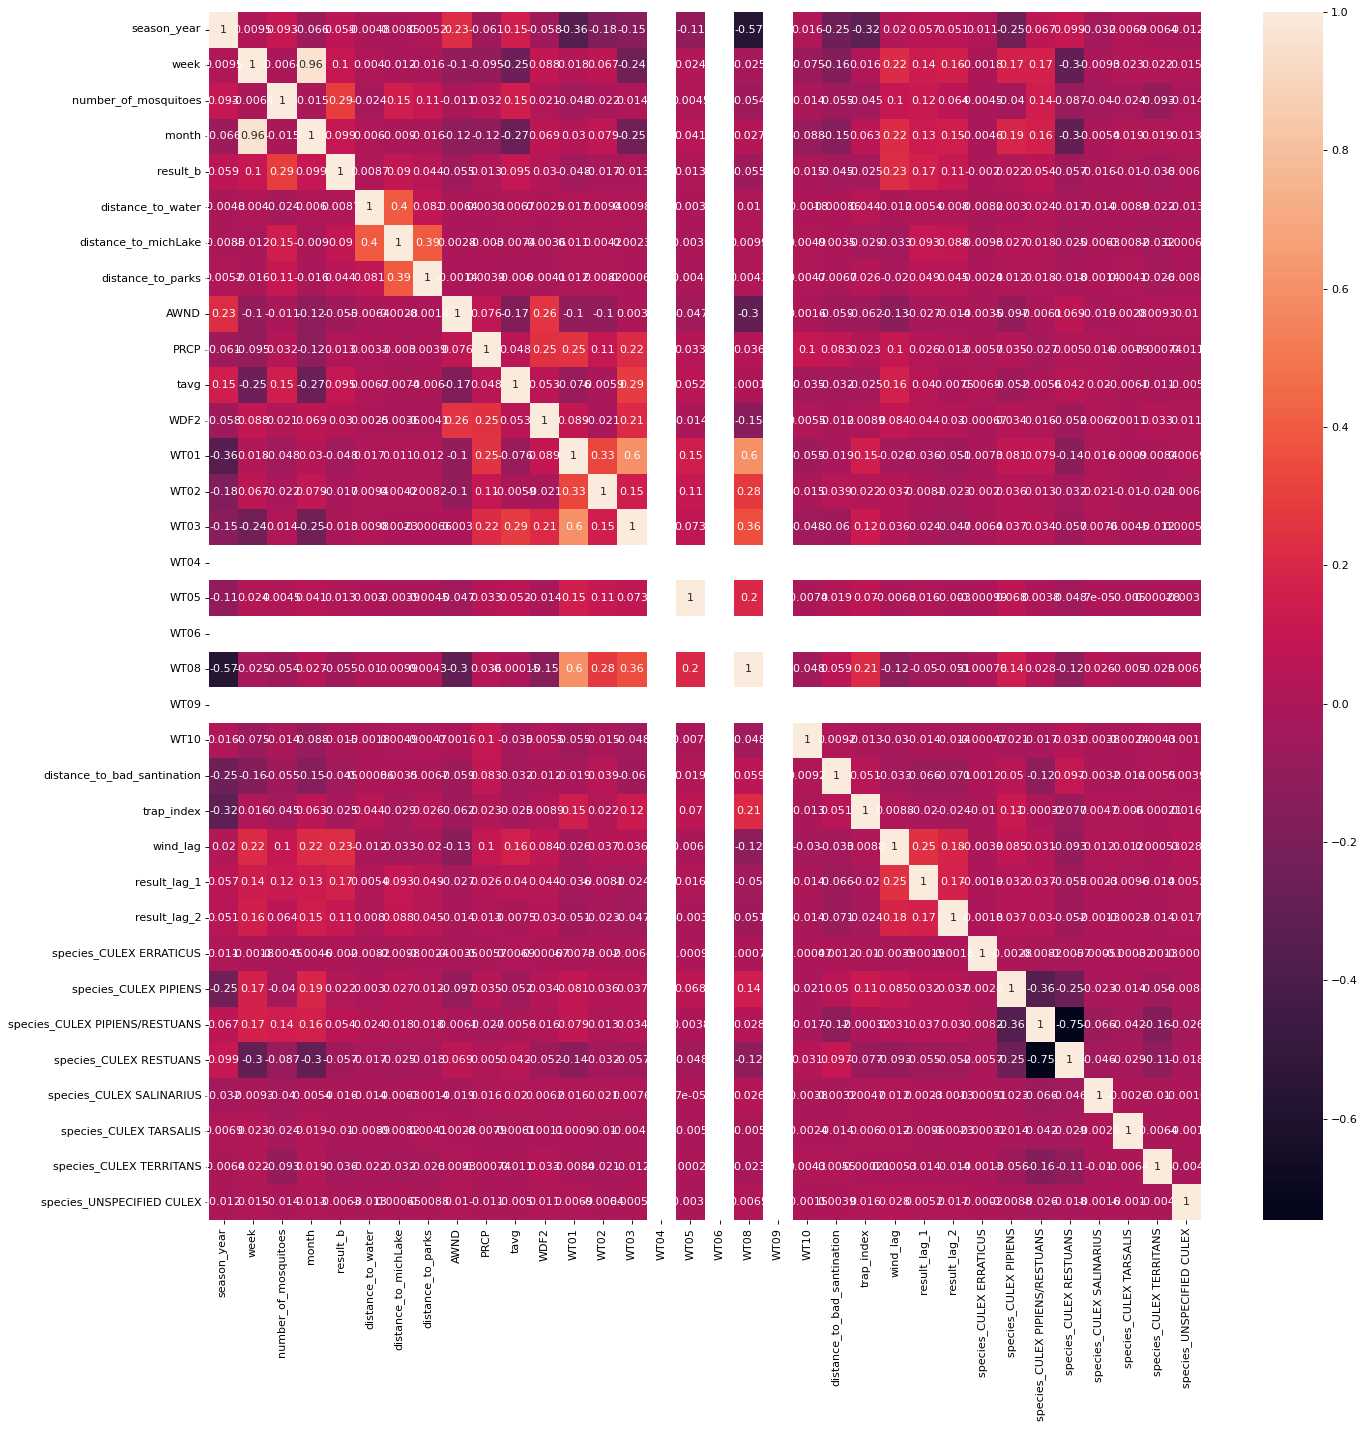

In [173]:
plt.figure(figsize=(20, 20), dpi=80)
corrMatrix = df_lag.corr()
sns.heatmap(corrMatrix, annot=True)


<AxesSubplot:>

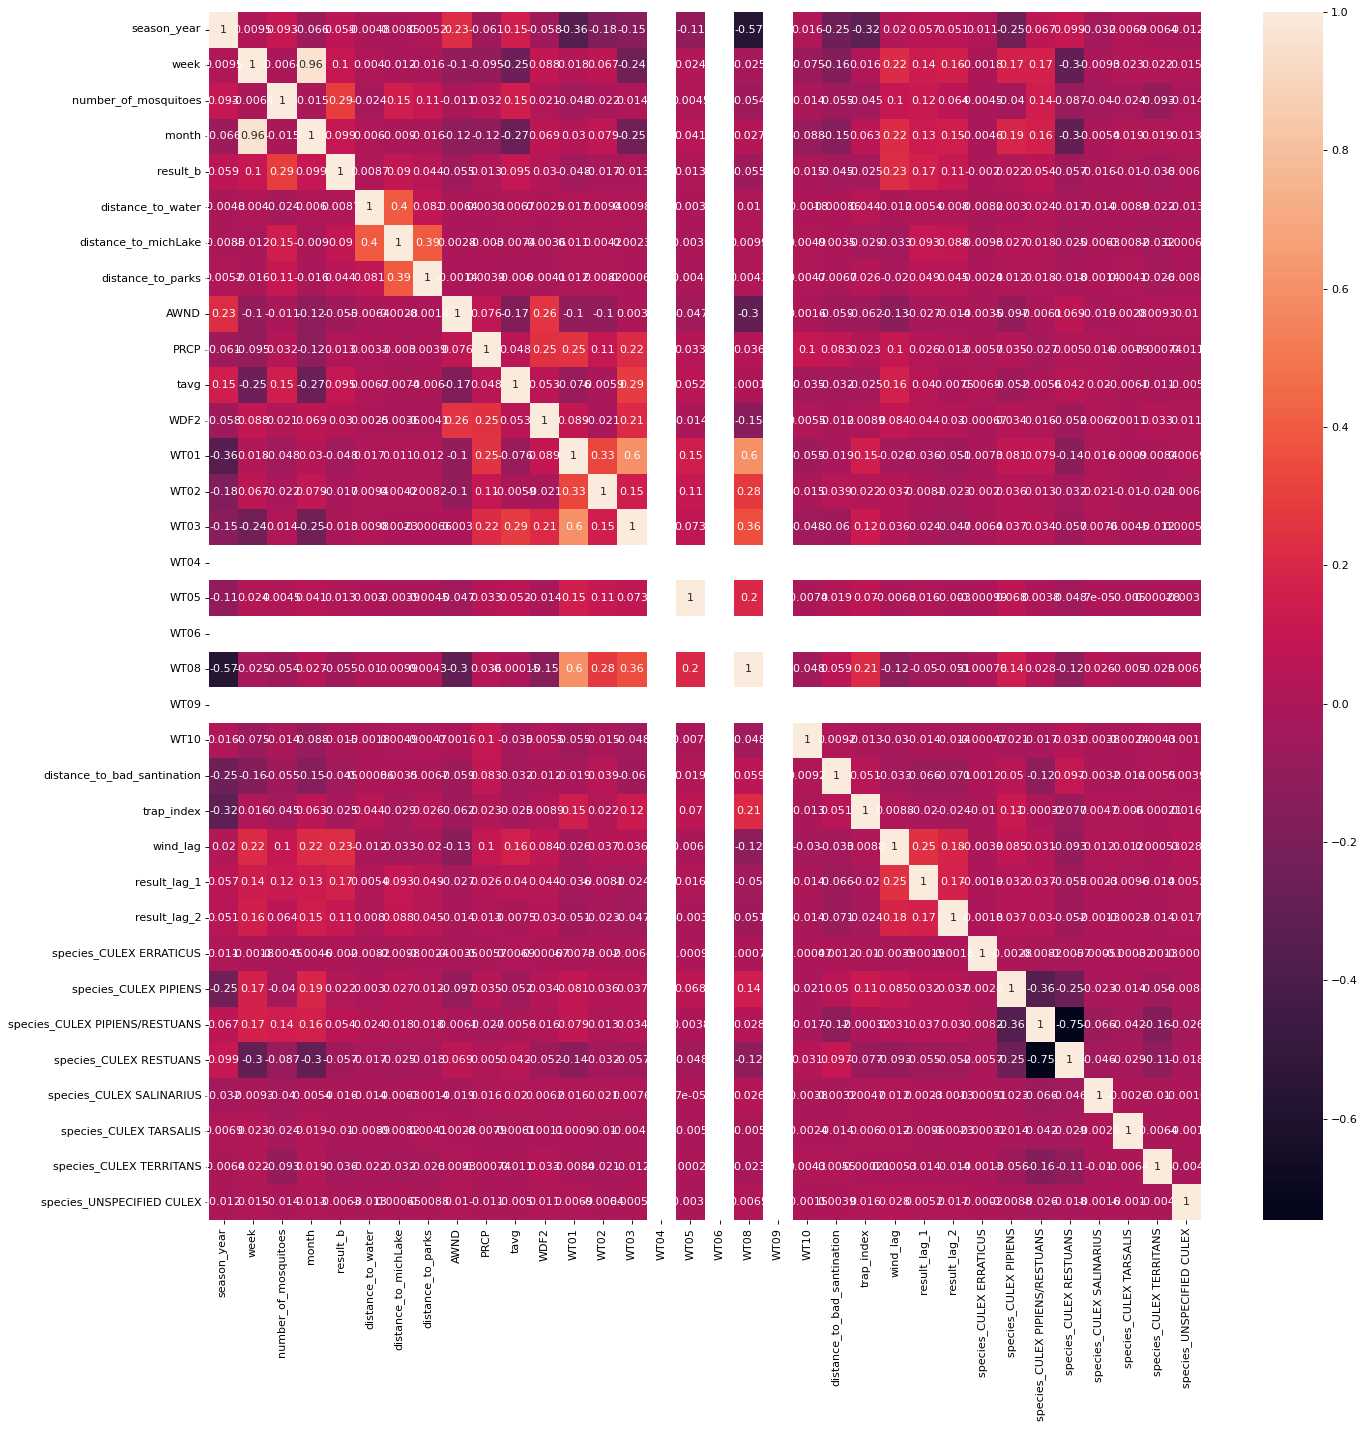

In [174]:
plt.figure(figsize=(20, 20), dpi=80)
corrMatrix = df_lag.corr()
sns.heatmap(corrMatrix, annot=True)

# model

## regression model

In [382]:
df_lag.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15868 entries, 0 to 15867
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   geometry_str                    15868 non-null  object  
 1   year_week                       15868 non-null  object  
 2   season_year                     15868 non-null  int64   
 3   week                            15868 non-null  int64   
 4   test_id                         15868 non-null  object  
 5   block                           15868 non-null  object  
 6   trap                            15868 non-null  object  
 7   trap_type                       15868 non-null  object  
 8   test_date                       15868 non-null  object  
 9   number_of_mosquitoes            15868 non-null  int64   
 10  result                          15868 non-null  object  
 11  species                         15868 non-null  object  
 12  month     

In [193]:
df_lag.columns

,index,geometry_str,year_week,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,month,result_b,geometry,distance_to_water,distance_to_michLake,distance_to_parks,AWND,PRCP,tavg,WDF2,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,distance_to_bad_santination,trap_index,wind_lag,result_lag_1,result_lag_2,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX
0,0,POINT (-87.660845069 42.010529289),2021/W39,2021,39,53373,12XX W GREENLEAF AVE,T018,GRAVID,2021-09-30T00:09:00,2,negative,CULEX PIPIENS/RESTUANS,9,0,POINT (-87.66085 42.01053),0.005725,0.000844,0.000077,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.009930,0,915.707937,0.0,0.0,0,0,1,0,0,0,0,0
1,1,POINT (-87.778909912 41.923887364),2021/W39,2021,39,53381,61XX W FULLERTON AVE,T013,GRAVID,2021-09-30T00:09:00,13,negative,CULEX PIPIENS/RESTUANS,9,0,POINT (-87.77891 41.92389),0.004473,0.138857,0.000653,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.013229,1,1200.623154,0.0,0.0,0,0,1,0,0,0,0,0
2,2,POINT (-87.600167559 41.773085401),2021/W39,2021,39,53406,10XX E 67TH ST,T073,GRAVID,2021-09-30T00:09:00,7,negative,CULEX PIPIENS/RESTUANS,9,0,POINT (-87.60017 41.77309),0.000914,0.025234,0.001209,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.004155,2,1169.636212,0.0,0.0,0,0,1,0,0,0,0,0
3,3,POINT (-87.754366286 41.778305156),2021/W39,2021,39,53401,52XX W 63RD ST,T065,GRAVID,2021-09-30T00:09:00,8,negative,CULEX PIPIENS/RESTUANS,9,0,POINT (-87.75437 41.77831),0.041485,0.159379,0.002211,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.016282,3,1164.217604,0.0,0.0,0,0,1,0,0,0,0,0
4,4,POINT (-87.764736532 41.872872862),2021/W39,2021,39,53383,5XX S CENTRAL AVE,T031,GRAVID,2021-09-30T00:09:00,5,positive,CULEX PIPIENS/RESTUANS,9,1,POINT (-87.76474 41.87287),0.002376,0.143607,0.000028,7.478571,0.007143,72.571429,114.285714,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.001440,4,1265.882532,0.0,0.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15863,15863,POINT (-87.656762124 41.896131093),2007/W21,2007,21,20025,11XX W CHICAGO AVE,T049,GRAVID,2007-05-29T00:05:00,1,negative,CULEX RESTUANS,5,0,POINT (-87.65676 41.89613),0.004580,0.033924,0.003258,10.001429,0.064286,68.428571,142.857143,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,40.000000,50,0.000000,0.0,0.0,0,0,0,1,0,0,0,0
15864,15864,POINT (-87.63105648 41.732428064),2007/W21,2007,21,20049,2XX W 89TH ST,T096,CDC,2007-05-29T00:05:00,1,negative,CULEX PIPIENS,5,0,POINT (-87.63106 41.73243),0.019899,0.070833,0.004350,10.001429,0.064286,68.428571,142.857143,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,40.000000,161,0.000000,0.0,0.0,0,1,0,0,0,0,0,0
15865,15865,POINT (-87.687601446 42.01780085),2007/W21,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,5,0,POINT (-87.68760 42.01780),0.024394,0.021481,0.005604,10.001429,0.064286,68.428571,142.857143,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,40.000000,99,0.000000,0.0,0.0,0,0,1,0,0,0,0,0
15866,15866,POINT (-87.678251676 41.68817059),2007/W21,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29T00:05:00,1,negative,CULEX PIPIENS/RESTUANS,5,0,POINT (-87.67825 41.68817),0.019688,0.135382,0.002928,10.001429,0.064286,68.428571,142.857143,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,40.000000,157,0.000000,0.0,0.0,0,0,1,0,0,0,0,0


In [305]:
df_trap_reg = df_lag.reset_index()

In [380]:
df_trap_reg['year_week'].sort_values()

15867    2007/W21
15849    2007/W21
15850    2007/W21
15851    2007/W21
15852    2007/W21
           ...   
32       2021/W39
31       2021/W39
30       2021/W39
28       2021/W39
0        2021/W39
Name: year_week, Length: 15868, dtype: object

In [331]:
X = df_trap_reg[['season_year', 
  'week', 'number_of_mosquitoes','distance_to_water', 'distance_to_michLake', 'distance_to_parks',
  'distance_to_bad_santination','AWND','PRCP','tavg','WDF2',
  'WT01', 'WT02', 'WT03', 'WT05', 'WT08', 'WT10','wind_lag',
  'result_lag_1','result_lag_2',
  'species_CULEX ERRATICUS', 'species_CULEX PIPIENS', 
  'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
  'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
  'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX'
  ]]

y = df_trap_reg['result_b']


In [333]:
X['wind_lag_log'] = np.log10(X['wind_lag']+1)
X.drop("wind_lag",axis=1,inplace=True)

In [309]:
X = pd.DataFrame(X)
X.columns = ['season_year', 
  'week', 'number_of_mosquitoes','distance_to_water', 'distance_to_michLake', 'distance_to_parks',
  'distance_to_bad_santination','AWND','PRCP','tavg','WDF2',
  'WT01', 'WT02', 'WT03', 'WT05', 'WT08', 'WT10','wind_lag',
  'result_lag_1','result_lag_2',
  'species_CULEX ERRATICUS', 'species_CULEX PIPIENS', 
  'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
  'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
  'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX'
  ]

In [334]:
results = sm.Logit(y, X,method='bfgs').fit()

         Current function value: 0.163544
         Iterations: 35


In [335]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:               result_b   No. Observations:                15868
Model:                          Logit   Df Residuals:                    15840
Method:                           MLE   Df Model:                           27
Date:                Thu, 28 Apr 2022   Pseudo R-squ.:                  0.2664
Time:                        20:15:34   Log-Likelihood:                -2595.1
converged:                      False   LL-Null:                       -3537.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
season_year                        0.0308      0.012      2.522      0.012       0.007       0.055
week                               0.0522      0.016      3.298      0.

In [ ]:
         Logit Regression Results                           
==============================================================================
Dep. Variable:               result_b   No. Observations:                15868
Model:                          Logit   Df Residuals:                    15840
Method:                           MLE   Df Model:                           27
Date:                Thu, 28 Apr 2022   Pseudo R-squ.:                  0.2664
Time:                        20:15:34   Log-Likelihood:                -2595.1
converged:                      False   LL-Null:                       -3537.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                                     coef  std err        z    P>|z|    [0.025    0.975]
---------------------------------------------------------------------------------------
season_year                       0.0308    0.012    2.522    0.012     0.007     0.055
week                              0.0522    0.016    3.298    0.001     0.021     0.083
number_of_mosquitoes              0.0576    0.002   23.828    0.000     0.053     0.062
distance_to_water                -3.1483    3.592   -0.876    0.381   -10.189     3.893
distance_to_michLake              6.2772    0.888    7.070    0.000     4.537     8.017
distance_to_parks                -1.6588    3.049   -0.544    0.586    -7.634     4.317
distance_to_bad_santination   -5.705e-05    0.005   -0.011    0.991    -0.010     0.010
AWND                             -0.1377    0.035   -3.954    0.000    -0.206    -0.069
PRCP                              0.1959    0.254    0.770    0.441    -0.303     0.694
tavg                              0.0375    0.011    3.515    0.000     0.017     0.058
WDF2                              0.0013    0.001    1.299    0.194    -0.001     0.003
WT01                             -0.0701    0.042   -1.661    0.097    -0.153     0.013
WT02                             -0.1393    0.191   -0.730    0.465    -0.513     0.235
WT03                              0.0191    0.047    0.406    0.685    -0.073     0.111
WT05                              0.3768    0.285    1.321    0.187    -0.182     0.936
WT08                             -0.0247    0.045   -0.552    0.581    -0.112     0.063
WT10                             -8.7232  183.961   -0.047    0.962  -369.279   351.833
result_lag_1                      0.4503    0.109    4.146    0.000     0.237     0.663
result_lag_2                      0.2297    0.120    1.917    0.055    -0.005     0.465
species_CULEX ERRATICUS         -85.8398 9861.920   -0.009    0.993 -1.94e+04  1.92e+04
species_CULEX PIPIENS           -71.8010   24.489   -2.932    0.003  -119.799   -23.803
species_CULEX PIPIENS/RESTUANS  -71.8812   24.513   -2.932    0.003  -119.925   -23.837
species_CULEX RESTUANS          -71.8389   24.512   -2.931    0.003  -119.881   -23.797
species_CULEX SALINARIUS       -154.0229 4.53e+17 -3.4e-16    1.000 -8.87e+17  8.87e+17
species_CULEX TARSALIS          -87.9549 3210.119   -0.027    0.978 -6379.673  6203.764
species_CULEX TERRITANS         -73.7517   24.517   -3.008    0.003  -121.804   -25.700
species_UNSPECIFIED CULEX       -96.7378  3.2e+05   -0.000    1.000 -6.26e+05  6.26e+05
wind_lag_log                      0.8170    0.054   15.206    0.000     0.712     0.922
=======================================================================================

In [48]:
spray

,Date,year_week,geometry
0,2011-08-29,2011/W35,"POLYGON ((-88.09390 42.38946, -88.09626 42.389..."
1,2011-09-07,2011/W36,"POLYGON ((-87.80245 41.96843, -87.81844 41.971..."
2,2013-07-17,2013/W29,"POLYGON ((-87.65954 41.71410, -87.87102 41.972..."
3,2013-07-25,2013/W30,"POLYGON ((-87.72105 41.93931, -87.73831 41.939..."
4,2013-08-08,2013/W32,"POLYGON ((-87.71370 41.91723, -87.71510 41.917..."
5,2013-08-15,2013/W33,"POLYGON ((-87.74859 41.88782, -87.76328 41.887..."
6,2013-08-16,2013/W33,"POLYGON ((-87.74962 41.91137, -87.78579 41.953..."
7,2013-08-22,2013/W34,"POLYGON ((-87.61589 41.71393, -87.61823 41.714..."
8,2013-08-29,2013/W35,"POLYGON ((-87.71181 41.75881, -87.71893 41.760..."
9,2013-09-05,2013/W36,"POLYGON ((-87.84571 41.97677, -87.84634 41.977..."


## SVM

train test split

In [387]:
df_trap_reg['week'] = df_trap_reg['week'].astype('float')

In [388]:
X = df_trap_reg[['season_year', 
  'week', 'number_of_mosquitoes','distance_to_water', 'distance_to_michLake', 'distance_to_parks',
  'distance_to_bad_santination','AWND','PRCP','tavg','WDF2',
  'WT01', 'WT02', 'WT03', 'WT05', 'WT08', 'WT10', 'wind_lag',
  'result_lag_1','result_lag_2',
  'species_CULEX ERRATICUS', 'species_CULEX PIPIENS',
  'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
  'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
  'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX'
  ]]
y = df_trap_reg['result_b']



In [389]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42)

In [390]:
print(f"Size of X: {len(X)}")
print(f"Size of y: {len(y)}")

Size of X: 15868
Size of y: 15868


In [391]:
set = y_train
ones = [i for i in set if i == 1]
zeroes = [i for i in set if i == 0]
print(f'LABELS - 1: {len(ones)}, 0: {len(zeroes)}, Ratio: {len(ones)/len(zeroes)}')

set = y_test
ones = [i for i in set if i == 1]
zeroes = [i for i in set if i == 0]
print(f'LABELS - 1: {len(ones)}, 0: {len(zeroes)}, Ratio: {len(ones)/len(zeroes)}') 

LABELS - 1: 652, 0: 10455, Ratio: 0.06236250597800096
LABELS - 1: 277, 0: 4484, Ratio: 0.06177520071364853


In [392]:
from sklearn.svm import SVC

svc = SVC(kernel = "sigmoid")

print('Train size: ' + str(y_train.shape[0]))

### Training the model
print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred = svc.predict(X_test)
print('Finished')

Train size: 11107
Training the model ...
Applying the model ...
Finished


In [393]:
print( f'Training Accuracy:   {100 * svc.score(X_train, y_train)}')
print( f'Testing Accuracy: {100 * np.sum(yPred==y_test) / y_test.shape[0]}')

Training Accuracy:   90.75357882416493
Testing Accuracy: 90.65322411258138


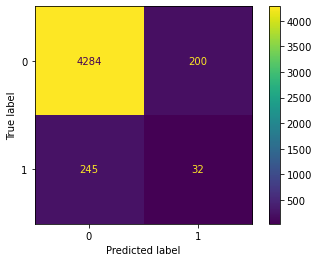

In [394]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [395]:
print('Precision: ' + str(34/(34+243)))

Precision: 0.12274368231046931


In [396]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, yPred, pos_label=1) # what is pos label?

In [397]:
 print(f"AUC = {metrics.auc(fpr, tpr)}")

AUC = 0.5354602163488634


## random forest

In [398]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()#使用默认参数将随机森林分类器实例化
rfc.fit(X_train,y_train)#模型拟合

RandomForestClassifier()

In [399]:
#评分方法1：
score1 = rfc.score(X_test,y_test)#查看拟合出的分类器在测试集上的效果
print(score1)

0.9453896240285654


In [400]:
#评分方法2：
from sklearn.metrics import roc_auc_score
proba = rfc.predict_proba(X_test)#使用分类器预测测试集中每个样本属于0和1的概率
score2 = roc_auc_score(y_test,proba[:,1])
print(score2)

0.8579985153791903


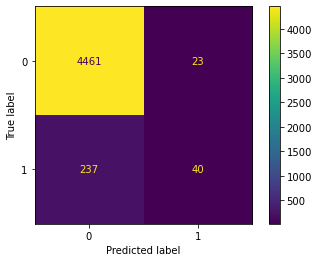

In [401]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = rfc.predict(X_test)

cm = confusion_matrix(y_test, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [402]:
print('Precision: ' + str(34/(34+243)))

Precision: 0.12274368231046931


In [403]:
from sklearn.model_selection import GridSearchCV
num_estimator = {'n_estimators':range(50,300,50)}#随机森林中树的棵数，以50为起点，50为步长，最多为300棵树
gs1 = GridSearchCV(estimator = rfc,param_grid = num_estimator,scoring='roc_auc',cv = 3)
gs1.fit(X_train,y_train)
print(gs1.best_estimator_)#查看最佳分类器
#返回值：RandomForestClassifier(n_estimators=200)
print(gs1.best_score_)#查看最佳分类器对应的得分

RandomForestClassifier(n_estimators=200)
0.8388898469326449


In [404]:
maxdepth = {'max_depth':range(3,10,1)}
gs2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 200),param_grid = maxdepth,scoring = 'roc_auc',cv = 3)
gs2.fit(X_train,y_train)
print(gs2.best_estimator_)

RandomForestClassifier(max_depth=8, n_estimators=200)


In [405]:
print(gs2.best_score_)#查看最佳分类器对应的得分


0.8625275253923887


In [406]:
minsamples = {'min_samples_split':range(2,50,2)}
gs3 = GridSearchCV(estimator = RandomForestClassifier(max_depth=8, n_estimators=200),param_grid = minsamples,scoring = 'roc_auc',cv = 3)
gs3.fit(X_train,y_train)
print(gs3.best_estimator_)

RandomForestClassifier(max_depth=8, min_samples_split=28, n_estimators=200)


In [407]:
print(gs3.best_score_)#查看最佳分类器对应的得分


0.8633724755033132


In [408]:
best_rfc = RandomForestClassifier(max_depth=8, min_samples_split=16, n_estimators=200)
best_rfc.fit(X_train,y_train)
print(best_rfc.score(X_test,y_test))

0.9439193446754883


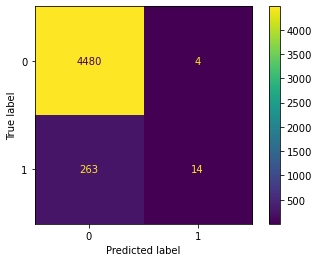

In [409]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = best_rfc.predict(X_test)

cm = confusion_matrix(y_test, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

Try to upsample the positive samples

In [410]:
# Try upsampling
from sklearn.utils import resample


def upsample_classes(data, target):
    
    lst = list(data[target].unique())
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    regroup = pd.concat(classes)
    maj_class = regroup[regroup[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    minority_classes = pd.concat(new_classes)
    upsample = pd.concat([regroup[regroup[target]==class_lab],minority_classes])

    return upsample

In [411]:
X_ = df_trap_reg[['season_year', 
  'week', 'number_of_mosquitoes','distance_to_water', 'distance_to_michLake', 'distance_to_parks',
  'distance_to_bad_santination','AWND','PRCP','tavg','WDF2',
  'WT01', 'WT02', 'WT03', 'WT05', 'WT08', 'WT10',
  'result_lag_1','result_lag_2','wind_lag',
  'species_CULEX ERRATICUS', 'species_CULEX PIPIENS',
  'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
  'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
  'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX'
  ]]
y_ = df_trap_reg['result_b']



In [412]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_, y_, train_size = 0.7, random_state=42)

In [413]:
train = pd.concat([X_train_2,y_train_2],axis=1)
train_balanced = (upsample_classes(train,'result_b'))
X_train_2 = train_balanced.drop(['result_b'],axis=1)
y_train_2 = train_balanced.result_b

In [414]:
from sklearn.model_selection import GridSearchCV
num_estimator = {'n_estimators':range(50,300,50)}#随机森林中树的棵数，以50为起点，50为步长，最多为300棵树
gs1 = GridSearchCV(estimator = rfc,param_grid = num_estimator,scoring='roc_auc',cv = 3)
gs1.fit(X_train_2,y_train_2)
print(gs1.best_estimator_)#查看最佳分类器
#返回值：RandomForestClassifier(n_estimators=200)
print(gs1.best_score_)#查看最佳分类器对应的得分

RandomForestClassifier(n_estimators=200)
0.9999996157612011


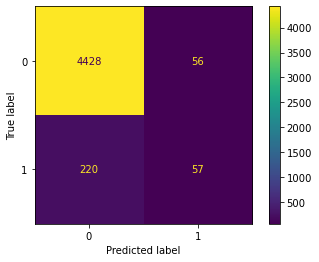

In [415]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = gs1.predict(X_test_2)

cm = confusion_matrix(y_test_2, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [416]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()#使用默认参数将随机森林分类器实例化
rfc.fit(X_train_2,y_train_2)#模型拟合

RandomForestClassifier()

In [417]:
#评分方法1：
score1 = rfc.score(X_test_2,y_test_2)#查看拟合出的分类器在测试集上的效果
print(score1)

0.939928586431422


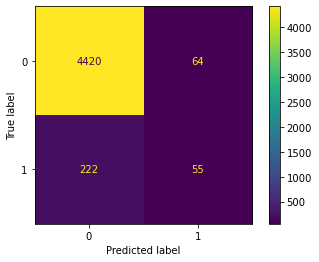

In [418]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = rfc.predict(X_test_2)

cm = confusion_matrix(y_test_2, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [419]:
print('Precision: ' + str(34/(34+243)))

Precision: 0.12274368231046931


## scaling + upsampling

In [420]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, train_size = 0.7, random_state=42)

In [421]:
# align index with x and y
X_train_2 = pd.DataFrame(X_train_2).set_index(y_train_2.index)

In [422]:
train = pd.concat([X_train_2,y_train_2],axis=1)
train


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,result_b
6092,0.274030,1.436294,-0.659126,0.298191,0.267990,-0.040448,0.154298,0.886264,2.384713,-0.520873,0.595180,-0.919751,-0.254821,-0.800628,-0.124447,-0.804871,-0.059511,-0.470972,-0.237461,-0.231176,-0.007939,2.848561,-1.036067,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,0
9365,-0.405818,1.643482,-0.310021,-0.501161,-0.576617,-0.182592,0.154298,0.145006,-0.814805,-2.234962,-0.706059,0.872097,-0.254821,-0.800628,-0.124447,-0.096081,-0.059511,-0.492455,-0.237461,-0.231176,-0.007939,2.848561,-1.036067,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,0
9804,-0.405818,-0.014023,-0.484573,-0.543947,-0.125125,-0.159780,0.154298,-1.063432,0.288797,1.465911,0.388165,-0.322468,3.482236,0.693564,-0.124447,-0.804871,-0.059511,7.914063,-0.237461,4.325714,-0.007939,-0.351054,-1.036067,1.388018,-0.064134,-0.040512,-0.158318,-0.025112,0
3336,0.953878,1.229106,-0.659126,-0.017825,-1.684692,-0.362675,0.154298,-1.527498,-0.814805,-0.442960,-1.741135,-0.919751,-0.254821,-0.800628,-0.124447,-0.096081,-0.059511,-0.444479,-0.237461,-0.231176,-0.007939,-0.351054,0.965188,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,0
8704,-0.179202,0.193165,0.737294,-0.400629,1.846550,0.014192,0.154298,-0.157104,-0.786983,0.232287,0.417738,-0.322468,-0.254821,-0.800628,-0.124447,-0.096081,-0.059511,0.423118,-0.237461,-0.231176,-0.007939,-0.351054,0.965188,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,-1.312283,1.643482,-0.659126,0.735125,0.051488,-0.409220,0.154298,-1.782889,-0.814805,-0.572815,-1.356678,1.469380,-0.254821,-0.800628,-0.124447,2.739081,-0.059511,-0.499280,-0.237461,-0.231176,-0.007939,-0.351054,0.965188,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,0
5390,0.500646,0.607541,0.213636,-0.530926,0.188020,-0.389063,0.154298,-0.272341,0.372262,0.453041,0.299444,-0.919751,-0.254821,-0.800628,-0.124447,-0.804871,-0.059511,4.075016,-0.237461,-0.231176,-0.007939,-0.351054,-1.036067,1.388018,-0.064134,-0.040512,-0.158318,-0.025112,1
860,1.633727,-1.464340,-0.659126,0.438687,-1.218373,-0.377178,0.154298,0.586231,0.251701,0.258258,-0.972221,0.274815,-0.254821,1.440659,-0.124447,-0.804871,-0.059511,-0.504167,-0.237461,-0.231176,-0.007939,-0.351054,-1.036067,1.388018,-0.064134,-0.040512,-0.158318,-0.025112,0
15795,-1.538899,-1.464340,-0.659126,-0.985655,0.339338,-0.364443,0.154298,-1.781851,-0.666422,0.803650,-1.031368,-0.919751,-0.254821,-0.053532,-0.124447,2.030290,-0.059511,-0.504167,-0.237461,-0.231176,-0.007939,-0.351054,0.965188,-0.720451,-0.064134,-0.040512,-0.158318,-0.025112,0


In [423]:
# upsample the train set
train = pd.concat([X_train_2,y_train_2],axis=1)
train_balanced = (upsample_classes(train,'result_b'))
X_train_2 = train_balanced.drop(['result_b'],axis=1)
y_train_2 = train_balanced.result_b

In [424]:
from sklearn.svm import SVC

svc = SVC(kernel = "sigmoid")

print('Train size: ' + str(y_train_2.shape[0]))

### Training the model
print('Training the model ...')
svc.fit(X_train_2, y_train_2)

print('Applying the model ...')
yPred = svc.predict(X_test_2)
print('Finished')

Train size: 20910
Training the model ...
Applying the model ...
Finished


In [425]:
print( f'Training Accuracy:   {100 * svc.score(X_train_2, y_train_2)}')
print( f'Testing Accuracy: {100 * np.sum(yPred==y_test_2) / y_test_2.shape[0]}')

Training Accuracy:   71.0234337637494
Testing Accuracy: 70.57340894770006


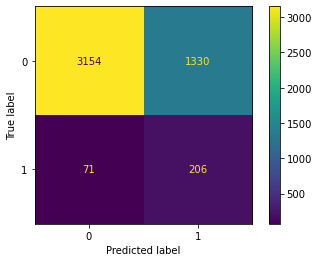

In [426]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_2, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [428]:
179/(98+179)

0.6462093862815884

In [429]:
print('Sensitivity: ' + str(cm[1,1]/cm[1].sum())) # TP / (TP + FN)
print('Precision: ' + str(cm[1,1]/cm[:,1].sum())) # TP / (TP + FP)


Sensitivity: 0.7436823104693141
Precision: 0.13411458333333334


In [430]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test_2, yPred, pos_label=1) # what is pos label?

In [431]:
 print(f"AUC = {metrics.auc(fpr, tpr)}")

AUC = 0.7235360704888943


Random forest

In [432]:
from sklearn.model_selection import GridSearchCV
num_estimator = {'n_estimators':range(50,300,50)}#随机森林中树的棵数，以50为起点，50为步长，最多为300棵树
gs1 = GridSearchCV(estimator = rfc,param_grid = num_estimator,scoring='roc_auc',cv = 3)
gs1.fit(X_train_2,y_train_2)
print(gs1.best_estimator_)#查看最佳分类器
#返回值：RandomForestClassifier(n_estimators=200)
print(gs1.best_score_)#查看最佳分类器对应的得分

RandomForestClassifier(n_estimators=200)
0.9999995608699441


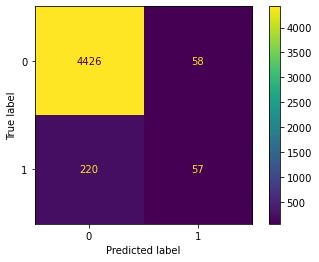

In [433]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = gs1.predict(X_test_2)

cm = confusion_matrix(y_test_2, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [434]:
print('Sensitivity: ' + str(cm[1,1]/cm[1].sum())) # TP / (TP + FN)
print('Precision: ' + str(cm[1,1]/cm[:,1].sum())) # TP / (TP + FP)


Sensitivity: 0.20577617328519857
Precision: 0.4956521739130435


In [441]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)#使用默认参数将随机森林分类器实例化
rfc.fit(X_train_2,y_train_2)#模型拟合

RandomForestClassifier(n_estimators=200)

In [442]:
#评分方法1：
score1 = rfc.score(X_test,y_test)#查看拟合出的分类器在测试集上的效果
print(score1)

0.9424490653224112


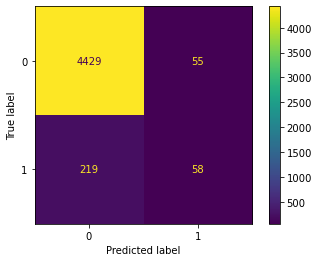

In [443]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
yPred = rfc.predict(X_test_2)

cm = confusion_matrix(y_test_2, yPred, labels=svc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels=svc.classes_)
disp.plot()

plt.show()

In [444]:
print('Sensitivity: ' + str(cm[1,1]/cm[1].sum())) # TP / (TP + FN)
print('Precision: ' + str(cm[1,1]/cm[:,1].sum())) # TP / (TP + FP)



Sensitivity: 0.20938628158844766
Precision: 0.5132743362831859


In [445]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_2, yPred, pos_label=1) # what is pos label?
print(f"AUC = {metrics.auc(fpr, tpr)}")

AUC = 0.5985602237558653
